In [8]:
import numpy as np
import cv2
import dlib
from dml import LDML
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imutils import face_utils
from skimage import data, feature, color, filters, img_as_float, io
from Marginal_knn import Marginal_knn
from matplotlib import pyplot as plt
import math
import glob

In [2]:
## Initialize DLib's shape predictor
shape_predictor = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

## Initilize OpenCV's SIFT detector
sift_detector = cv2.xfeatures2d.SIFT_create()

def get_landmark_points(image, rect):
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    rect = dlib.rectangle(rect[0], rect[1], rect[0]+rect[2], rect[1]+rect[3])
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
    #print(shape)
    #kp_idx = [36, 39, 42, 45, 31, 33, 35, 48, 54]
    #for i in kp_idx:
    #cv2.circle(image, (shape[i][0], shape[i][1]), 2, (0, 0, 255), -1)
    #cv2.imwrite("img"+str(np.random.randint(0,1000))+".jpg", image)
    #plt.figure(figsize=(10,10))
    #plt.axis("off")
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.show()
    return shape

In [3]:
def get_sift_descriptors(images):
    kp_idx = [36, 39, 42, 45, 31, 33, 35, 48, 54]
    scale = 0.7
    descriptors = []
    for img in images:
        img_des = []
        if len(img.shape) > 2:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        gray = gray.astype(np.uint8)
        
        #print(keypoints[0].pt[1])
        tmp_gray = gray.copy()
        for j in range(3):
            face_rect = (0,0,tmp_gray.shape[1]-1, tmp_gray.shape[0]-1)
            landmarks = get_landmark_points(tmp_gray, face_rect)
            keypoints = [cv2.KeyPoint(landmarks[i][0], landmarks[i][1], 1) for i in kp_idx]
            kp,des = sift_detector.compute(tmp_gray,keypoints)
            #img=cv2.drawKeypoints(tmp_gray,kp,tmp_gray,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            #cv2.imwrite('sift'+str(j)+".jpg",img)
            des = des.flatten()
            img_des.append(des)
            if j == 2:
                break
            tmp_gray = cv2.resize(tmp_gray,None,fx=0.7,fy=0.7, interpolation=cv2.INTER_AREA)
            #keypoints = [cv2.KeyPoint(keypoints[k].pt[0]*0.7, keypoints[k].pt[1]*0.7, 1) for k in range(len(keypoints))]
        img_des = np.array(img_des).flatten()
        descriptors.append(img_des)
        #plt.figure(figsize=(10,10))
        #plt.axis("off")
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.show()
        
    #print("Pair ", i+1, " computed")
    return descriptors

In [4]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
def get_face(files):
    faces = []
    for file in files:
        image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if len(image.shape) > 2:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        face = face_cascade.detectMultiScale(gray, 1.3, 5)
        if len(face) == 0:
            return faces, False
        face = gray[face[0][0]:face[0][0]+face[0][2], face[0][1]:face[0][1]+face[0][3]]
        #face = cv2.resize(face, (150,150)) #(47,62)
        #plt.imshow(face)
        #cv2.imshow('face',face)
        #cv2.waitKey(0)
        #face = face.flatten()
        faces.append(face)
        '''
        img = image.copy()
        for (x,y,w,h) in faces:
            img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
        
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
        '''
    return faces, True

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def get_acc(y_pred, y_pred_prob, method):
    lmnn_positive_count = 0
    y_pair_actual = []
    y_pair_pred = []
    counter=0
    for i in range(len(X_test)-1):
        for j in range(i+1,len(X_test)):
            if y_test[i]==y_test[j]:
                y_pair_actual.append(1)
            else:
                y_pair_actual.append(0)
            if method == 'knn':
                if y_pred[i]==y_pred[j]:
                    y_pair_pred.append(max(max(y_pred_prob[i]),max(y_pred_prob[j])))
                else:
                    y_pair_pred.append(0)
                if y_test[i]==y_test[j] and y_pred[i]==y_pred[j]:
                    lmnn_positive_count+=1
                if y_test[i]!=y_test[j] and y_pred[i]!=y_pred[j]:
                    lmnn_positive_count+=1
            if method == 'mknn':
                if y_pred[counter] > 0.5:
                    y_pair_pred.append(1)
                    lmnn_positive_count+=1
                else:
                    y_pair_pred.append(0)
            counter+=1
            
    #print(lmnn_positive_count, ((len(X_test)*(len(X_test)-1))))
    lmnn_acc = lmnn_positive_count*2/((len(X_test)*(len(X_test)-1)))
    return lmnn_acc, y_pair_actual, y_pair_pred
    
def roc_auc_curve(y_pair_actual, y_pair_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_pair_actual, y_pair_pred)  #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_pair_actual, y_pair_pred)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #print(roc_auc)
    return roc_auc, fpr, tpr

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.filterwarnings("ignore")

# Load a data set
bunch = fetch_olivetti_faces(data_home = './data')
bunch.images *=255
images = bunch.images.astype('uint8')
#print(img)
#plt.imshow(img[10])

#print(type(bunch.data))
sift_data = get_sift_descriptors(images)
pca = PCA(n_components=200)
output_pca = pca.fit_transform(sift_data)
#print(output_pca.shape)
#print(np.shape(bunch.data))

X_train, X_test, y_train, y_test = train_test_split(output_pca, bunch.target, train_size=0.7, random_state=42)#, stratify=y, random_state=42)
print(np.shape(X_train), np.shape(X_test))

(280, 200) (120, 200)


In [11]:
k_neighbors = [3,5,7,10]
n_components, max_iter = X_train.shape[1], 180

ldml_acc_knn, roc_knn, fpr_knn, tpr_knn = [],[],[],[] 
ldml_acc_mknn, roc_mknn, fpr_mknn, tpr_mknn = [],[],[],[]

# Instantiate the metric learner
ldml_instance = LDML(initial_metric='euclidean', max_iter=100, eta0 = 0.1, b=0.01) #initial_metric=np.identity(np.shape(X_train)[1], dtype=float), upper_bound=1, lower_bound=1, gamma=1, max_iter=1000
ldml_instance.fit(np.asarray(X_train), np.asarray(y_train))
ldml_train_op = ldml_instance.transform(np.asarray(X_train))
ldml_test_op = ldml_instance.transform(np.asarray(X_test))
for k in k_neighbors:
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(ldml_train_op, y_train)
    
    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    #lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
    
    y_pred_prob = knn.predict_proba(ldml_test_op)
    y_pred = knn.predict(ldml_test_op)
    k_score = ldml_acc = knn.score(ldml_test_op, y_test)
    print(k_score)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='knn')
    #print(y_pair_pred)
    ldml_acc_knn.append(acc)
    roc_auc1, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pair_pred)
    roc_knn.append(roc_auc1)
    fpr_knn.append(fpr_)
    tpr_knn.append(tpr_)
    
    Mknn = Marginal_knn(n_neighbors=k)
    Mknn.fit(ldml_train_op, y_train)
    y_pred = Mknn.predict(ldml_test_op)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='mknn')
    ldml_acc_mknn.append(acc)
    roc_auc2, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pred)
    roc_mknn.append(roc_auc2)
    fpr_mknn.append(fpr_)
    tpr_mknn.append(tpr_)
    print("ROC-AUC score with ",str(k)," neighbors")
    print("K-NN:", roc_auc1['micro'], "\tM-KNN:", roc_auc2['micro'])

0.7666666666666667
ROC-AUC score with  3  neighbors
K-NN: 0.8239547787536362 	M-KNN: 0.9620633111434327
0.6833333333333333
ROC-AUC score with  5  neighbors
K-NN: 0.7285090694226897 	M-KNN: 0.9585316031270977
0.6583333333333333
ROC-AUC score with  7  neighbors
K-NN: 0.7183321912060864 	M-KNN: 0.9621712596498098
0.5916666666666667
ROC-AUC score with  10  neighbors
K-NN: 0.7015446688297158 	M-KNN: 0.9443064374021034


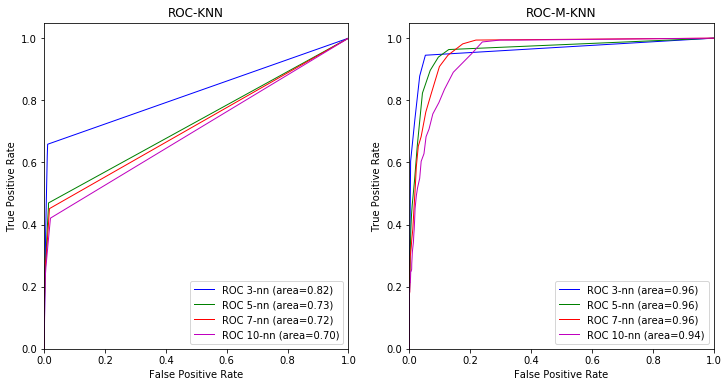

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-KNN')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-M-KNN')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
lw = 1
x = 0
color = ['b', 'g', 'r', 'm']
for i in range(len(k_neighbors)):
    ax1.plot(fpr_knn[i][x], tpr_knn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_knn[i][x])
    ax2.plot(fpr_mknn[i][x], tpr_mknn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_mknn[i][x])
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
plt.show()

In [14]:
#-- Read file conatining image paths ---#
files = glob.glob('./extract/*')
#name_file = open('./all_images.txt', 'r')
#lines = name_file.readlines()

In [16]:
#--- Read images, prepare training and testing dataset ---#
images = []
labels = []
label_count = 0
#face_train, face_test, y_train, y_test = [], [], [], []
for file in files:
    #print(line)
    img_files = glob.glob(file+'/*')
    name, count = img_files[0].split('/')[-2].split('.')[0], len(img_files)
    if int(count)>11 :
        #files = glob.glob('./lfw-deepfunneled/'+name+'/*')
        #print(line)
        faces, flag = get_face(img_files)
        if flag:
            tmp = 0
            for i in range(10): #for face in faces: 
                #if tmp!=2 and tmp != 3 and tmp!=6 and tmp!=9 and tmp !=11 and tmp!=13:
                '''
                if tmp != 3 and tmp!=5 and tmp!=6: #and tmp!=9 and tmp!=11:
                    face_train.append(faces[i])
                    y_train.append(label_count)
                else:
                    face_test.append(faces[i])
                    y_test.append(label_count)
                tmp+=1
                '''
                images.append(faces[i])
                labels.append(label_count)
            label_count+=1
        else:
            pass
            #print("Notfound")

n_classes = label_count
print("Number of classes:",n_classes)
#print("Training data shape:",np.shape(face_train)," Testing data shape:", np.shape(face_test))

Number of classes: 53


In [17]:
sift_data = get_sift_descriptors(images)#[0:1800]
print("Feature size after SIFT: ",np.shape(sift_data))
X_train, X_test, y_train, y_test = train_test_split(sift_data, labels, train_size=0.8, random_state=420)#, stratify=y, random_state=42)

Feature size after SIFT:  (530, 3456)


In [19]:
pca = PCA(n_components=0.9)
X_train = pca.fit_transform(X_train)
print("PCA output shape (95% of info) ",np.shape(X_train))
X_test = pca.transform(X_test)

PCA output shape (95% of info)  (424, 122)


In [20]:
k_neighbors = [3,5,7,10]
n_components, max_iter = X_train.shape[1], 180

ldml_acc_knn, roc_knn, fpr_knn, tpr_knn = [],[],[],[] 
ldml_acc_mknn, roc_mknn, fpr_mknn, tpr_mknn = [],[],[],[]

# Instantiate the metric learner
ldml_instance = LDML(initial_metric='euclidean', max_iter=100, eta0 = 0.1, b=0.01) #initial_metric=np.identity(np.shape(X_train)[1], dtype=float), upper_bound=1, lower_bound=1, gamma=1, max_iter=1000
ldml_instance.fit(np.asarray(X_train), np.asarray(y_train))
ldml_train_op = ldml_instance.transform(np.asarray(X_train))
ldml_test_op = ldml_instance.transform(np.asarray(X_test))
for k in k_neighbors:
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(ldml_train_op, y_train)
    
    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    #lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
    
    y_pred_prob = knn.predict_proba(ldml_test_op)
    y_pred = knn.predict(ldml_test_op)
    k_score = ldml_acc = knn.score(ldml_test_op, y_test)
    print(k_score)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='knn')
    #print(y_pair_pred)
    ldml_acc_knn.append(acc)
    roc_auc1, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pair_pred)
    roc_knn.append(roc_auc1)
    fpr_knn.append(fpr_)
    tpr_knn.append(tpr_)
    
    Mknn = Marginal_knn(n_neighbors=k)
    Mknn.fit(ldml_train_op, y_train)
    y_pred = Mknn.predict(ldml_test_op)
    acc, y_pair_actual, y_pair_pred = get_acc(y_pred, y_pred_prob, method='mknn')
    ldml_acc_mknn.append(acc)
    roc_auc2, fpr_, tpr_ = roc_auc_curve(y_pair_actual, y_pred)
    roc_mknn.append(roc_auc2)
    fpr_mknn.append(fpr_)
    tpr_mknn.append(tpr_)
    print("ROC-AUC score with ",str(k)," neighbors")
    print("K-NN:", roc_auc1['micro'], "\tM-KNN:", roc_auc2['micro'])

0.1320754716981132
ROC-AUC score with  3  neighbors
K-NN: 0.5076539827498732 	M-KNN: 0.6057564687975647
0.1509433962264151
ROC-AUC score with  5  neighbors
K-NN: 0.5225844748858447 	M-KNN: 0.6221380010147133
0.1320754716981132
ROC-AUC score with  7  neighbors
K-NN: 0.5190208016235414 	M-KNN: 0.6043003551496703
0.12264150943396226
ROC-AUC score with  10  neighbors
K-NN: 0.5209183155758498 	M-KNN: 0.6729700659563673


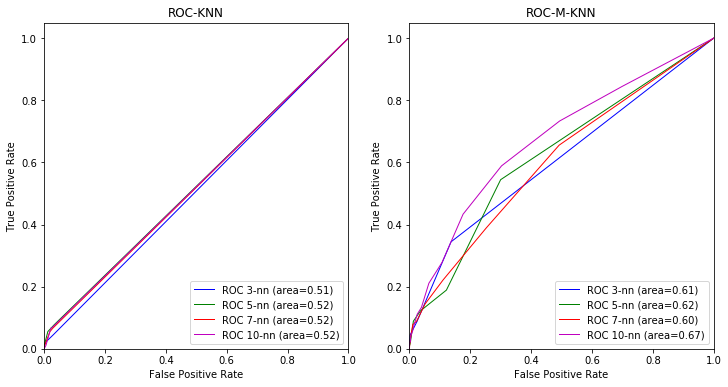

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-KNN')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-M-KNN')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
lw = 1
x = 0
color = ['b', 'g', 'r', 'm']
for i in range(len(k_neighbors)):
    ax1.plot(fpr_knn[i][x], tpr_knn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_knn[i][x])
    ax2.plot(fpr_mknn[i][x], tpr_mknn[i][x], color=color[i],
             lw=lw, label='ROC '+str(k_neighbors[i])+'-nn (area=%0.2f)' % roc_mknn[i][x])
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
plt.show()

In [9]:
ldml_instance = LDML(initial_metric='euclidean', max_iter=100, eta0 = 0.1, b=0.01) #initial_metric=np.identity(np.shape(X_train)[1], dtype=float), upper_bound=1, lower_bound=1, gamma=1, max_iter=1000
ldml_instance.fit(np.asarray(X_train), np.asarray(y_train))
print('Fit done')
#print(ldml_instance.metric())
ldml_train_op = ldml_instance.transform(np.asarray(X_train))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Fit done


In [10]:
k_test = 3
knn = KNeighborsClassifier(n_neighbors=k_test)
knn.fit(ldml_train_op, y_train)
print(ldml_train_op.shape)

(925, 123)


In [11]:
ldml_test_op = ldml_instance.transform(np.asarray(X_test))
print(np.shape(y_test))
ldml_acc = knn.score(ldml_test_op, y_test)
print('LDML accuracy on test set of {} points: {:.4f}'.format(len(X_test[0]), ldml_acc))

(200,)
LDML accuracy on test set of 123 points: 0.2650


In [13]:
knn = KNeighborsClassifier(n_neighbors=k_test)
knn.fit(ldml_train_op, y_train)
y_pred = knn.predict(X_test)
ldml_positive_count = 0
y_pair_actual = []
y_pair_pred = []
for i in range(len(X_test)-1):
    for j in range(i+1,len(X_test)):
        if y_test[i]==y_test[j]:
            y_pair_actual.append(1)
        else:
            y_pair_actual.append(0)
        if y_pred[i]==y_pred[j]:
            y_pair_pred.append(1)
        else:
            y_pair_pred.append(0)
        if y_test[i]==y_test[j] and y_pred[i]==y_pred[j]:
            ldml_positive_count+=1
        if y_test[i]!=y_test[j] and y_pred[i]!=y_pred[j]:
            ldml_positive_count+=1
print(ldml_positive_count, ((len(X_test)*(len(X_test)-1))))
ldml_acc = ldml_positive_count*2/((len(X_test)*(len(X_test)-1)))
#itml_acc = knn.score(lmnn.transform(X_test), y_test)
print('LDML accuracy on test set of {} points: {:.4f}'.format(len(X_test[0]), ldml_acc))

400 39800
LDML accuracy on test set of 123 points: 0.0201


In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_pair_actual, y_pair_pred)  #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_pair_actual, y_pair_pred)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(roc_auc)

{0: 0.5, 1: 0.5, 'micro': 0.5}


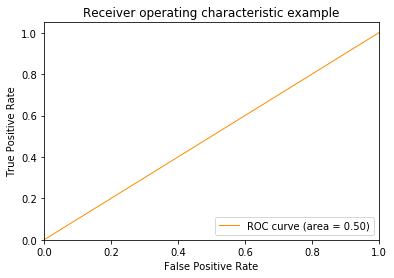

In [15]:
plt.figure()
lw = 1
x = 0
plt.plot(fpr[x], tpr[x], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[x])
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score

y_prob = knn.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.500000 (macro),
0.500000 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.500000 (macro),
0.500000 (weighted by prevalence)


In [20]:
from Marginal_knn import Marginal_knn

Mknn = Marginal_knn(n_neighbors=k_test)
Mknn.fit(ldml_train_op, y_train)
y_pair_pred = Mknn.predict(X_test)

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_pair_actual, y_pair_pred)  #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_pair_actual, y_pair_pred)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(roc_auc)

{0: 0.5, 1: 0.5, 'micro': 0.5}


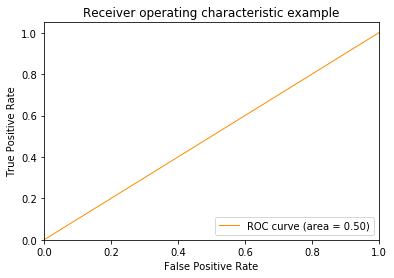

In [22]:
plt.figure()
lw = 1
x = 0
plt.plot(fpr[x], tpr[x], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[x])
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [23]:
macro_roc_auc_ovo = roc_auc_score(y_pair_actual, y_pair_pred, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_pair_actual, y_pair_pred, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_pair_actual, y_pair_pred, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_pair_actual, y_pair_pred, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.500000 (macro),
0.500000 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.500000 (macro),
0.500000 (weighted by prevalence)
